# [Gluon] Convolutional Neural Network for Sentence Classification

## Data Preperation

## http://www.cs.cornell.edu/people/pabo/movie-review-data/

In [4]:
## 데이터 전처리:
## https://github.com/apache/incubator-mxnet/tree/master/example/cnn_text_classification

In [5]:
from __future__ import print_function

from collections import Counter
import itertools
import numpy as np
import re

from urllib.request import urlopen

In [6]:
def download_sentences(url):
    """
    Download sentences from specified URL. 
    
    Strip trailing newline, convert to Unicode.
    """
    
    remote_file = urlopen(url)
    return [line.decode('Latin1').strip() for line in remote_file.readlines()]
    
def load_data_and_labels():
    """
    Loads polarity data from files, splits the data into words and generates labels.
    Returns split sentences and labels.
    """

    positive_examples = download_sentences('https://raw.githubusercontent.com/yoonkim/CNN_sentence/master/rt-polarity.pos')
    negative_examples = download_sentences('https://raw.githubusercontent.com/yoonkim/CNN_sentence/master/rt-polarity.neg')
    
    # Tokenize
    x_text = positive_examples + negative_examples
    x_text = [clean_str(sent).split(" ") for sent in x_text]

    # Generate labels
    positive_labels = [1 for _ in positive_examples]
    negative_labels = [0 for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    return x_text, y

In [7]:
def clean_str(string):
    """
    Tokenization/string cleaning.
    Original from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    
    return string.strip().lower()

In [8]:
def pad_sentences(sentences, padding_word=""):
    """
    Pads all sentences to be the length of the longest sentence.
    Returns padded sentences.
    """
    ## sentences 길이 중 가장 긴 길이 기준
    sequence_length = max(len(x) for x in sentences)
    
    ## padding은 문장에 따라 가변적으로 생성
    padded_sentences = []
    for i in range(len(sentences)):
        sentence = sentences[i]
        ## 문장길이 - 현재 sentence
        num_padding = sequence_length - len(sentence)
        ## 문장 뒤에 padding
        new_sentence = sentence + [padding_word] * num_padding
        padded_sentences.append(new_sentence)
        
    return padded_sentences, sequence_length

In [9]:
# Load and preprocess data
sentences, labels = load_data_and_labels()
# padding 처리
sentences_padded, sequence_length = pad_sentences(sentences)

In [10]:
print (sequence_length)

56


In [11]:
## 다른 모형에서도 동일한 데이터 사용을 위해 저장

In [12]:
import pickle
import gzip
import pandas as pd

In [13]:
with gzip.open('data_sets.pickle', 'wb') as f:
    pickle.dump(pd.DataFrame.from_dict({'X':[' '.join(i) for i in sentences], 'Y':labels}), f)

## EDA

### Sentences And Labels

In [14]:
def print_eda(idx):
    print ('Orgin: ' + ' '.join(sentences[idx]))
    print ('Padded: ' + '_'.join(sentences_padded[idx]))
    print ('Label: ' + str(labels[idx]))

In [15]:
print_eda(10)

Orgin: this is a film well worth seeing , talking and singing heads and all
Padded: this_is_a_film_well_worth_seeing_,_talking_and_singing_heads_and_all__________________________________________
Label: 1


In [16]:
print_eda(7000)

Orgin: at its best , queen is campy fun like the vincent price horror classics of the '60s at its worst , it implodes in a series of very bad special effects
Padded: at_its_best_,_queen_is_campy_fun_like_the_vincent_price_horror_classics_of_the_'60s_at_its_worst_,_it_implodes_in_a_series_of_very_bad_special_effects_________________________
Label: 0


In [17]:
print (labels)

[1 1 1 ... 0 0 0]


In [18]:
print (Counter(labels))

Counter({1: 5331, 0: 5331})


In [19]:
## Shuffling 필요

### Change Text to Index

In [20]:
def build_vocab(sentences):
    """
    Builds a vocabulary mapping from token to index based on the sentences.
    Returns vocabulary mapping and inverse vocabulary mapping.
    """
    # Build vocabulary
    word_counts = Counter(itertools.chain(*sentences))
    
    # Mapping from index to word
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    
    # Mapping from word to index
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    
    return vocabulary, vocabulary_inv

vocabulary, vocabulary_inv = build_vocab(sentences_padded)

In [21]:
word_counts = Counter(itertools.chain(*sentences))

In [22]:
word_counts.most_common()[0:5]

[('the', 10194), (',', 10037), ('a', 7341), ('and', 6264), ('of', 6148)]

In [23]:
def build_input_data(sentences, labels, vocabulary):
    """
    Maps sentences and labels to vectors based on a vocabulary.
    """
    x = np.array([
            [vocabulary[word] for word in sentence]
            for sentence in sentences])
    y = np.array(labels)
    
    return x, y

In [24]:
x, y = build_input_data(sentences_padded, labels, vocabulary)

In [25]:
print (x[0])

[    1   565     7  2633     6    22     1  3369   887     8   100  5598
     4    11    65     8   240     6    73     3  3913    57  2948    34
  1489  2393     2  2394 10111  1708  7197    42   937 10112     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [26]:
print (sentences_padded[0])

['the', 'rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'century', "'s", 'new', 'conan', 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger', ',', 'jean', 'claud', 'van', 'damme', 'or', 'steven', 'segal', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


In [27]:
print (vocabulary['the'])

1


In [28]:
print (vocabulary_inv[1])

the


In [26]:
vocab_size = len(vocabulary)

In [27]:
print (vocab_size)

18766


## PreProcessing

In [28]:
# randomly shuffle data
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

In [29]:
# split train/test set
# there are a total of 10662 labeled examples to train on
x_train, x_test = x_shuffled[:-1000], x_shuffled[-1000:]
y_train, y_test = y_shuffled[:-1000], y_shuffled[-1000:]

sentence_size = x_train.shape[1]

print('Train/Test split: %d/%d' % (len(y_train), len(y_test)))
print('train shape:', x_train.shape)
print('Test shape:', x_test.shape)
print('vocab_size', vocab_size)
print('sentence max words', sentence_size)

Train/Test split: 9662/1000
train shape: (9662, 56)
Test shape: (1000, 56)
vocab_size 18766
sentence max words 56


In [30]:
import mxnet as mx
from mxnet import nd, autograd, gluon, init
from mxnet.gluon.data import ArrayDataset, DataLoader
import numpy as np
import multiprocessing
from mxnet.gluon import nn

In [31]:
class MovieReviewDataSet(ArrayDataset):
    # We pre-process the documents on the fly
    def __getitem__(self, idx):
        return self._data[0][idx], self._data[1][idx]

In [32]:
train_dataset = MovieReviewDataSet(x_train, y_train)
test_dataset = MovieReviewDataSet(x_test, y_test)

In [33]:
BATCH_SIZE = 128
NUM_WORKERS = 3

In [34]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, last_batch='discard')
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, last_batch='discard')

In [35]:
ctx = mx.gpu() # to run on GPU

## Model

In [36]:
NUM_FILTERS = 256 # number of convolutional filters per convolutional layer
NUM_OUTPUTS = len(set(labels)) # number of classes
DROPOUT_RATE = 0.5 # probability of node drop out
LEARNING_RATE = 0.01 # learning rate of the gradient
EMB_OUT = 128
FILTER_SIZES = [3, 4, 5]
FULLY_CONNECTED = 128

In [37]:
MOMENTUM = 0.9 # momentum of the gradient
WDECAY = 0.00001 # regularization term to limit size of weights

### 1D_00

In [38]:
class TextCNN_1D_00(gluon.HybridBlock):
    def __init__(self, vocab_size, sequence_length, embed_size, conv_channel, filter_sizes, num_classes, batch_size, **kwargs):
        self.conv_channel = conv_channel
        self.filter_sizes = filter_sizes
        self.vocab_size = vocab_size
        self.sequence_length = sequence_length
        self.embed_size = embed_size
        self.batch_size = batch_size
        super(TextCNN_1D_00, self).__init__(**kwargs)
        
        with self.name_scope():
                        
            self.embed = nn.Embedding(input_dim=vocab_size, output_dim=embed_size)

            self.conv0 = nn.Conv1D(channels=conv_channel, kernel_size=filter_sizes[0], activation='relu')
            self.pool0 = nn.MaxPool1D(pool_size=(sequence_length - filter_sizes[0] + 1))
                        
            self.conv1 = nn.Conv1D(channels=conv_channel, kernel_size=filter_sizes[1], activation='relu')
            self.pool1 = nn.MaxPool1D(pool_size=(sequence_length - filter_sizes[1] + 1))
            
            self.conv2 = nn.Conv1D(channels=conv_channel, kernel_size=filter_sizes[2], activation='relu')
            self.pool2 = nn.MaxPool1D(pool_size=(sequence_length - filter_sizes[2] + 1))
            
            self.drop1 = nn.Dropout(0.5)
            self.out = nn.Dense(num_classes)
           
    def hybrid_forward(self, F, x):
        ## batch * 56
        ## x
        
        ## batch * 56 > batch * 56 * 128
        embedded_vectors = self.embed(x)
        
        ## batch *  56 * 128 > batch * 128 * 56
        embedded_vectors = F.swapaxes(embedded_vectors, 1,2)
                
        
        ## Output Size
        #(W - F_w + 2*P)/S_w + 1  : W = 폭, F = 필터 폭, P = padding 사이즈, S = Stride 사이즈 : (56 - 3 + 2*0)/1 + 1 = 54
        #(H - F_h + 2*P)/S_h + 1  : 
        
        ## batch * 128 * 56 > batch * 256 * 54 
        conv0_out = self.conv0(embedded_vectors) ## NCW
        ## batch * 128 * 56 > batch * 256 * 53
        conv1_out = self.conv1(embedded_vectors)
        ## batch * 128 * 56 > batch * 256 * 52
        conv2_out = self.conv2(embedded_vectors)

        ## batch * 256 * 54 > batch * 256 * 1: pool_size(54)
        pool0_out = self.pool0(conv0_out)
        ## batch * 256 * 53 > batch * 256 * 1: pool_size(53)
        pool1_out = self.pool1(conv1_out)
        ## batch * 256 * 52 > batch * 256 * 1: pool_size(52)
        pool2_out = self.pool2(conv2_out)
        
        ## batch * [[256 * 1], [256 * 1], [256 * 1]]  
        con_list = [pool0_out, pool1_out, pool2_out]
                
        ## batch * [768* 1] : 768 = 256 *3
        fc1_input = F.concat(*con_list, dim=1)
        
        ## batch * [768 * 1]
        fc1_output = self.drop1(fc1_input)
                                        
        ## batch * 2    
        output = self.out(fc1_output)
        return output

In [39]:
net_1d_00 = TextCNN_1D_00(vocab_size, sequence_length, EMB_OUT, NUM_FILTERS, FILTER_SIZES, NUM_OUTPUTS, BATCH_SIZE)
shape = (8, 56)

### 네트워크 관찰

In [40]:
# for speed improvement, compile the network but no in-depth debugging possible
hybridize = True 
if hybridize:
    net_1d_00.hybridize()

In [41]:
print (net_1d_00)

TextCNN_1D_00(
  (embed): Embedding(18766 -> 128, float32)
  (conv0): Conv1D(None -> 256, kernel_size=(3,), stride=(1,), Activation(relu))
  (pool0): MaxPool1D(size=(54,), stride=(54,), padding=(0,), ceil_mode=False)
  (conv1): Conv1D(None -> 256, kernel_size=(4,), stride=(1,), Activation(relu))
  (pool1): MaxPool1D(size=(53,), stride=(53,), padding=(0,), ceil_mode=False)
  (conv2): Conv1D(None -> 256, kernel_size=(5,), stride=(1,), Activation(relu))
  (pool2): MaxPool1D(size=(52,), stride=(52,), padding=(0,), ceil_mode=False)
  (drop1): Dropout(p = 0.5, axes=())
  (out): Dense(None -> 2, linear)
)


In [42]:
mx.viz.print_summary(
    net_1d_00(mx.sym.var('data')), 
    shape={'data':shape}
)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                          56                      0                                           
________________________________________________________________________________________________________________________
textcnn_1d_000_embedding0_fwd(Embedding)            56x128                  0           data                            
________________________________________________________________________________________________________________________
textcnn_1d_000_swapaxes0(SwapAxis)                  128x56                  0           textcnn_1d_000_embedding0_fwd   
________________________________________________________________________________________________________________________
textcnn_1d_000_conv0_fwd(Convolu

In [43]:
# (F_o  * F_i * F_w * F_h) + F_o (Bias) : F_o = 아웃풋 채널수(필터수) , F_i = 인풋 채널수,  F_w = 필터 가로폭, F_h = 필터 세로폭
## 여기서 인풋 채널 수는 데이터 길이

In [44]:
256 * 128 * 3 * 1 + 256

98560

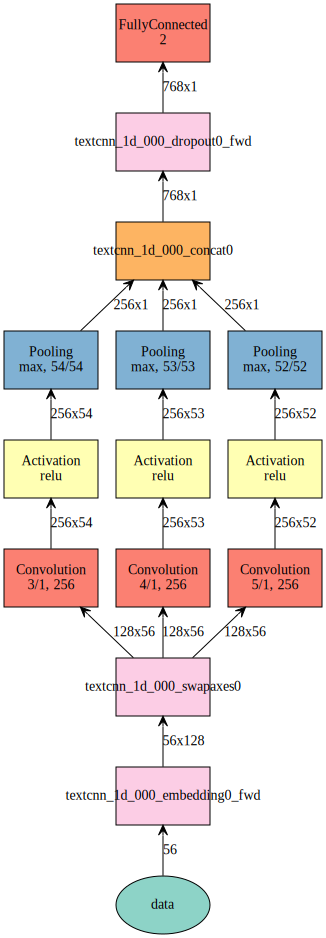

In [45]:
mx.viz.plot_network(
    net_1d_00(mx.sym.var('data')), 
    shape={'data':shape}
)

In [46]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.predict_mode():
            output = net(data)
        
        prediction = nd.argmax(output, axis=1)

        if (i%50 == 0):
            print("Samples {}".format(i*len(data)))
        acc.update(preds=prediction, labels=label)
    return acc.get()[1]

In [47]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [48]:
def run_model(net, start_epoch = 0, number_epochs = 50, smoothing_constant = .01):
    net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)    
    trainer = gluon.Trainer(net.collect_params(), 'sgd', 
                        {'learning_rate': LEARNING_RATE, 
                         'wd':WDECAY, 
                         'momentum':MOMENTUM})
    
    train_accuracy = mx.metric.Accuracy()
    
    for e in range(start_epoch, number_epochs):
        for i, (review, label) in enumerate(train_dataloader):
            review = review.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record(train_mode=True):
                output = net(review)
                loss = softmax_cross_entropy(output, label)
            loss.backward()
            trainer.step(review.shape[0])
            
            prediction = nd.argmax(output, axis=1)
            train_accuracy.update(preds=prediction, labels=label)

            # moving average of the loss
            curr_loss = nd.mean(loss).asscalar()
            moving_loss = (curr_loss if (i == 0) 
                           else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)

        test_accuracy = evaluate_accuracy(test_dataloader, net)
        
        print("Epoch %s. Loss: %s, Training_acc %s" % (e, round(moving_loss, 4), round(train_accuracy.get()[1],4)))
        print("Epoch %s. Loss: %s, Test_acc %s" % (e, round(moving_loss, 4), round(test_accuracy,4)))
    return net

In [49]:
net_1d_00 = run_model(net_1d_00)

Samples 0
Epoch 0. Loss: 0.6936, Training_acc 0.5045
Epoch 0. Loss: 0.6936, Test_acc 0.481
Samples 0
Epoch 1. Loss: 0.6917, Training_acc 0.5065
Epoch 1. Loss: 0.6917, Test_acc 0.4821
Samples 0
Epoch 2. Loss: 0.6921, Training_acc 0.5109
Epoch 2. Loss: 0.6921, Test_acc 0.5625
Samples 0
Epoch 3. Loss: 0.6898, Training_acc 0.5199
Epoch 3. Loss: 0.6898, Test_acc 0.5156
Samples 0
Epoch 4. Loss: 0.6899, Training_acc 0.5279
Epoch 4. Loss: 0.6899, Test_acc 0.5435
Samples 0
Epoch 5. Loss: 0.6861, Training_acc 0.5337
Epoch 5. Loss: 0.6861, Test_acc 0.5379
Samples 0
Epoch 6. Loss: 0.6848, Training_acc 0.5369
Epoch 6. Loss: 0.6848, Test_acc 0.5513
Samples 0
Epoch 7. Loss: 0.6791, Training_acc 0.5393
Epoch 7. Loss: 0.6791, Test_acc 0.5391
Samples 0
Epoch 8. Loss: 0.6824, Training_acc 0.5411
Epoch 8. Loss: 0.6824, Test_acc 0.5435
Samples 0
Epoch 9. Loss: 0.6798, Training_acc 0.5429
Epoch 9. Loss: 0.6798, Test_acc 0.5469
Samples 0
Epoch 10. Loss: 0.681, Training_acc 0.5446
Epoch 10. Loss: 0.681, Test_

In [50]:
net_1d_00.save_parameters('best.params')

## 과제

class TextCNN_2D_00(gluon.HybridBlock):
    def __init__(self, vocab_size, sequence_length, embed_size, conv_channel, filter_sizes, num_classes, batch_size, **kwargs):
        self.conv_channel = conv_channel
        self.filter_sizes = filter_sizes
        self.vocab_size = vocab_size
        self.sequence_length = sequence_length
        self.embed_size = embed_size
        self.batch_size = batch_size
        super(TextCNN_2D_00, self).__init__(**kwargs)
        
        with self.name_scope():
            
            self.embed = 
            self.conv0 = 
            self.pool0 = 
            
            self.conv1 = 
            self.pool1 = 
            
            self.conv2 =
            self.pool2 = 
            
            self.drop1 = 
            self.out = 

    def hybrid_forward(self, F, x):
        ## batch * 56
        ## x
        
        return output

net_2d_00 = TextCNN_2D_00(vocab_size, sequence_length, EMB_OUT, NUM_FILTERS, FILTER_SIZES, NUM_OUTPUTS, BATCH_SIZE)
shape = (1, 56)

net_2d_00

mx.viz.print_summary(
    net_2d_00(mx.sym.var('data')), 
    shape={'data':shape}
)

net_2d_00 = run_model(net_2d_00)

## Post Process

### EDA: Trainded Word Vector

In [56]:
from mxnet import nd
def cos_sim(x, y):
    return nd.dot(x, y) / (nd.norm(x) * nd.norm(y))

def norm_vecs_by_row(x):
    return x / nd.sqrt(nd.sum(x * x, axis=1)).reshape((-1,1))

def get_knn(vocab_vec, vocab_vecs, k):#, word):
    word_vec = vocab_vec.reshape((-1, 1))
    vocab_vecs = norm_vecs_by_row(vocab_vecs)
    dot_prod = nd.dot(vocab_vecs, word_vec)
    indices = nd.topk(dot_prod.reshape((vocab_size )), k=k+1, ret_typ='indices')
    indices = [int(i.asscalar()) for i in indices]
    return list(np.array(vocabulary_inv)[indices])

In [57]:
net = net_1d_00

In [58]:
import gluonnlp as nlp

In [59]:
keys = [i for i in list(net.collect_params().keys()) if 'embedding' in i]
print (keys)

['textcnn_1d_000_embedding0_weight']


In [60]:
embed_vec = net.collect_params()[keys[0]].data()

In [61]:
get_knn(embed_vec[vocabulary.get('excellent', '_')], embed_vec, 5)

['excellent', 'gentle', 'history', 'unique', 'unlike', 'won']

In [62]:
get_knn(embed_vec[vocabulary.get('worse', '_')], embed_vec, 5)

['worse', 'boring', 'loses', 'plodding', 'grating', 'shoot']

### Grad-Cam

In [63]:
class TextCNN_1D_01(gluon.HybridBlock):
    def __init__(self, vocab_size, sequence_length, embed_size, conv_channel, filter_sizes, num_classes, batch_size, **kwargs):
        self.conv_channel = conv_channel
        self.filter_sizes = filter_sizes
        self.vocab_size = vocab_size
        self.sequence_length = sequence_length
        self.embed_size = embed_size
        self.batch_size = batch_size
        super(TextCNN_1D_01, self).__init__(**kwargs)
        
        with self.name_scope():
                        
            self.embed = nn.Embedding(input_dim=vocab_size, output_dim=embed_size)

            self.conv0 = nn.Conv1D(channels=conv_channel, kernel_size=filter_sizes[0], activation='relu')
            self.pool0 = nn.MaxPool1D(pool_size=(sequence_length - filter_sizes[0] + 1))
                        
            self.conv1 = nn.Conv1D(channels=conv_channel, kernel_size=filter_sizes[1], activation='relu')
            self.pool1 = nn.MaxPool1D(pool_size=(sequence_length - filter_sizes[1] + 1))
            
            self.conv2 = nn.Conv1D(channels=conv_channel, kernel_size=filter_sizes[2], activation='relu')
            self.pool2 = nn.MaxPool1D(pool_size=(sequence_length - filter_sizes[2] + 1))
            
            #self.drop1 = nn.Dropout(0.5)
            self.out = nn.Dense(num_classes)
           
    def hybrid_forward(self, F, x):
        ## batch * 56
        ## x
        
        ## batch * 56 > batch * 56 * 128
        embedded_vectors = self.embed(x)
        
        ## batch *  56 * 128 > batch * 128 * 56
        embedded_vectors = F.swapaxes(embedded_vectors, 1,2)
                
        ## batch * 128 * 56 > batch * 256 * 54 
        conv0_out = self.conv0(embedded_vectors) ## NCW
        ## batch * 128 * 56 > batch * 256 * 53
        conv1_out = self.conv1(embedded_vectors)
        ## batch * 128 * 56 > batch * 256 * 52
        conv2_out = self.conv2(embedded_vectors)

        ## batch * 256 * 54 > batch * 256 * 1: pool_size(54)
        pool0_out = self.pool0(conv0_out)
        ## batch * 256 * 53 > batch * 256 * 1: pool_size(53)
        pool1_out = self.pool1(conv1_out)
        ## batch * 256 * 52 > batch * 256 * 1: pool_size(52)
        pool2_out = self.pool2(conv2_out)
        
        ## batch * [[256 * 1], [256 * 1], [256 * 1]]  
        con_list = [pool0_out, pool1_out, pool2_out]
                
        ## batch * [768* 1] : 768 = 256 *3
        fc1_input = F.concat(*con_list, dim=1)
        
        ## batch * [768 * 1]
        #fc1_output = self.drop1(fc1_input)
                                        
        ## batch * 2    
        output = self.out(fc1_input)
        return conv0_out, output

In [64]:
net_1d_01 = TextCNN_1D_01(vocab_size, sequence_length, EMB_OUT, NUM_FILTERS, FILTER_SIZES, NUM_OUTPUTS, BATCH_SIZE)
shape = (1, 56)
net_1d_01.hybridize()

In [65]:
_, out = net_1d_01(mx.sym.var('data'))

In [66]:
mx.viz.print_summary(
    out, 
    shape={'data':shape}
)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                          56                      0                                           
________________________________________________________________________________________________________________________
textcnn_1d_010_embedding0_fwd(Embedding)            56x128                  0           data                            
________________________________________________________________________________________________________________________
textcnn_1d_010_swapaxes0(SwapAxis)                  128x56                  0           textcnn_1d_010_embedding0_fwd   
________________________________________________________________________________________________________________________
textcnn_1d_010_conv0_fwd(Convolu

In [67]:
import cv2

![image](imgs/grad_cam.png)

In [68]:
def grad_cam_conv1D(net, x, y, loss, ctx, params_name='gradcam.params'):
    net.load_parameters(params_name, ctx=ctx)
    conv_keys = [i for i in list(net.collect_params().keys()) if ('conv' in i) and ('weight' in i)]
    last_conv_layer_name = conv_keys[len(conv_keys) -1]
    
    with autograd.record():
            acts, output = net(nd.array([x,],ctx=ctx))
            loss_ = loss(output, nd.array([y,],ctx=ctx))
            output = nd.SoftmaxActivation(output)
            loss_.backward()
    
    ## acts: Batch * NUM_FILTERS * OUT_CONV (1, 256, 54)
    ## output : Batch * NUM_OUTPUTS (1, 2)
    
    ## F_o  * F_i * F_w  (256, 128, 3) : # F_o = 아웃풋 채널수(NUM_FILTERS) , F_i = 인풋 채널수,  F_w = 필터 가로폭
    net_grad = net.conv0.weight.grad()
        
    #a_{k}^{c}:  F_o (256)
    filter_grad = nd.mean(net_grad, axis=(1,2)) # i, j
                
    #L_{Grad-CAM}^c : (21L ~ 32L)
    for i in range(acts.shape[1]):
        acts[:,i,:] *= filter_grad[i]
    
    ## 1장만: NUM_FILTERS * OUT_CONV (256, 54)
    acts = nd.squeeze(acts, axis=(0)).asnumpy()
    
    ## sequence_length * OUT_CONV (56 * 256)
    acts =cv2.resize(acts, (sequence_length, NUM_FILTERS))
    
    ##  sequence_length (56, )
    heat = nd.relu(nd.sum(nd.array(acts), axis=0))

    return(heat.asnumpy(), loss_)

In [69]:
idx = 0

In [70]:
print_eda(shuffle_indices[idx])

Orgin: demands too much of most viewers
Padded: demands_too_much_of_most_viewers__________________________________________________
Label: 0


In [71]:
heat, loss = grad_cam_conv1D(net_1d_01, x_train[idx], y_train[idx], softmax_cross_entropy, ctx, 'best.params')

In [72]:
heat

array([1.4592699e-06, 2.6545322e-05, 3.9265883e-06, 1.5500223e-06,
       6.3334511e-07, 1.2662942e-06, 6.8907229e-07, 4.5485484e-07,
       4.5485484e-07, 4.5485484e-07, 4.5485484e-07, 4.5485484e-07,
       4.5485484e-07, 4.5485484e-07, 4.5485484e-07, 4.5485484e-07,
       4.5485484e-07, 4.5485484e-07, 4.5485484e-07, 4.5485484e-07,
       4.5485484e-07, 4.5485484e-07, 4.5485484e-07, 4.5485484e-07,
       4.5485484e-07, 4.5485484e-07, 4.5485484e-07, 4.5485484e-07,
       4.5485484e-07, 4.5485484e-07, 4.5485484e-07, 4.5485484e-07,
       4.5485484e-07, 4.5485484e-07, 4.5485484e-07, 4.5485484e-07,
       4.5485484e-07, 4.5485484e-07, 4.5485484e-07, 4.5485484e-07,
       4.5485484e-07, 4.5485484e-07, 4.5485484e-07, 4.5485484e-07,
       4.5485484e-07, 4.5485484e-07, 4.5485484e-07, 4.5485484e-07,
       4.5485484e-07, 4.5485484e-07, 4.5485484e-07, 4.5485484e-07,
       4.5485484e-07, 4.5485484e-07, 4.5485484e-07, 4.5485484e-07],
      dtype=float32)

In [73]:
len([vocabulary_inv[int(i)] for i in x_train[idx]])

56

In [74]:
len(heat)

56

In [75]:
import pandas as pd
hm_tbl = pd.DataFrame({'heat':heat, 'kw':[vocabulary_inv[int(i)] for i in x_train[idx]]})

In [76]:
hm_tbl.drop_duplicates(inplace=True)
hm_tbl.sort_values(by='heat', inplace=True, ascending=False)

In [77]:
hm_tbl

,heat,kw
1,2.654532e-05,too
2,3.926588e-06,much
3,1.550022e-06,of
0,1.459270e-06,demands
5,1.266294e-06,viewers
6,6.890723e-07,
4,6.333451e-07,most
7,4.548548e-07,


In [78]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

/home/ubuntu/python/venv/ngram_detectors/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


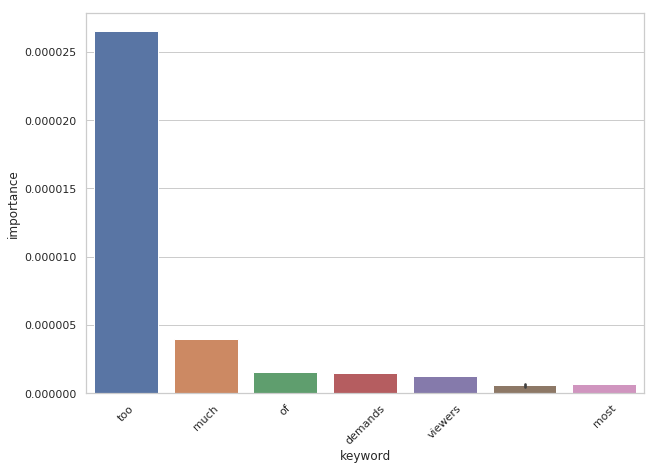

In [79]:
import seaborn as sns
sns.set(style="whitegrid")
rcParams.update({'font.size': 17})
plt.figure(figsize=(10,7))

ax = sns.barplot(x="kw", y="heat", data=hm_tbl[:20])
plt.xticks(rotation=45)
plt.ylabel('importance')
plt.xlabel('keyword')
plt.savefig('importances.png', dpi=300)